# Periodic Solid

We solve the Schrödinger equation for a periodic potential in 1D. The original equation for $\psi$,
$$
(-\frac{1}{2} \Delta + V(x)) \psi(x) = \lambda psi(x) \quad \text{on } \mathbb R,
$$
can be rewritten in terms of solutions on a unit cell. For a given $k$, $\psi$ can be written as $\psi(x) = e^{i k x} u(x)$ where the periodic function $u$ solves the equation
$$
\left(- \frac{1}{2} (ik + \nabla)^2 + V(x)\right) u(x) = \lambda u(x) \quad \text{on } [0, 1).
$$
The ground state density $\rho$ of $\psi$ can then be reconstructed using an integral over $k$ in the dual unit cell $[-\pi, \pi)$,
$$
\rho(x, y) = \int_{-\pi}^\pi \psi_{0, k}(x) \psi_{0, k}(y)^* dk
$$

## Discretization

The problem is discretized using a pseudo spectral method. For a real space grid $x = (x_1 = 0, x_2 = \Delta x, \dotsc, x_N = 1 - \frac{1}{N})$, the corresponding Fourier grid $\omega = [-N/2 + 1, \dotsc, \frac{N}{2})$ is used.

preudo spectral method

In [1]:
using Plots
using LaTeXStrings

Nₓ = 200
x = linspace(0, 1., Nₓ + 1)[1:end-1]
ω = vcat(0.:(Nₓ / 2), (-Nₓ / 2 + 1):-1)
V = -50 * exp(-100 * (x - 1 / 2).^2)
Nₖ = 102
k = linspace(-pi, pi, Nₖ + 1)[1:end-1]

linspace(-3.141592653589793,3.0799927976370522,102)

Custom linear operator type `BlochHamiltonian` for matrix free eigenvalue computation. The custom type has to support the functions `*`, `size`, `eltype`, and `issym` for the Arnoldi iteration in the eigensolver to work.

In [2]:
type BlochHamiltonian{T} <: AbstractMatrix{T}
    k::T
    ω::Vector{T}
    V::Vector{T}
end

import Base: *, size, eltype, issym
*(H::BlochHamiltonian, v::Vector) = -1 / 2 * (im * H.k + 2π * im * H.ω).^2 .* v + fft(H.V .* ifft(v))
size(H::BlochHamiltonian) = (length(H.V), length(H.V))
eltype{T}(H::BlochHamiltonian{T}) = Complex{T}
issym(H::BlochHamiltonian) = false

issym (generic function with 12 methods)

We solve for `nev = 5` eigenvalues and eigenfunctions. They are sotred in the arrays `E` and `Ψ`.

In [3]:
nev = 5
E = zeros(nev, Nₖ)
Ψ = complex(zeros(Nₓ, nev, Nₖ))
@time for r = 1:Nₖ
    H = BlochHamiltonian(k[r], ω, V)
    (λ, û) = eigs(H, nev=nev, which=:SR)
    E[:, r] = real(λ)
    u = ifft(û, 1)
    Ψ[:, :, r] = exp(im * x * k[r]) .* u * sqrt(Nₓ)
end

ρ = complex(zeros(Nₓ, Nₓ))
for r = 1:Nₖ
    ρ += vec(Ψ[:, 1, r]) * vec(Ψ[:, 1, r])'
end
ρ *= 2π / Nₖ;

 44.879119 seconds (39.21 M allocations: 8.714 GB, 4.57% gc time)


200x200 Array{Complex{Float64},2}:
           0.00118804+0.0im  …  0.000592904-1.38381e-17im 
  0.00118857+1.68322e-18im       0.00061203-9.33091e-18im 
  0.00119015+2.36938e-18im      0.000631704-4.86064e-18im 
    0.0011928+2.6612e-18im      0.000651944-9.37388e-19im 
  0.00119651+1.98315e-18im      0.000672767+2.44039e-18im 
  0.00120129+3.39934e-19im   …  0.000694193+5.23347e-18im 
  0.00120713-1.94701e-18im      0.000716239+7.33761e-18im 
  0.00121405-4.37492e-18im      0.000738927+8.89134e-18im 
  0.00122205-7.23415e-18im      0.000762275+9.04928e-18im 
  0.00123114-9.97485e-18im      0.000786304+7.94143e-18im 
  0.00124132-1.07187e-17im   …  0.000811036+7.45861e-18im 
  0.00125262-1.24763e-17im      0.000836492+4.97905e-18im 
  0.00126502-1.25409e-17im      0.000862696+4.10769e-18im 
                     ⋮       ⋱                            
  0.00083583+1.85736e-17im       0.00127929-1.39582e-17im 
 0.000810435+1.96016e-17im         0.0012657-1.4002e-17im 
 0.000785765+2.06282e

We plot the ground state density in one unit cell.

[Plots.jl] Initializing backend: pyplot



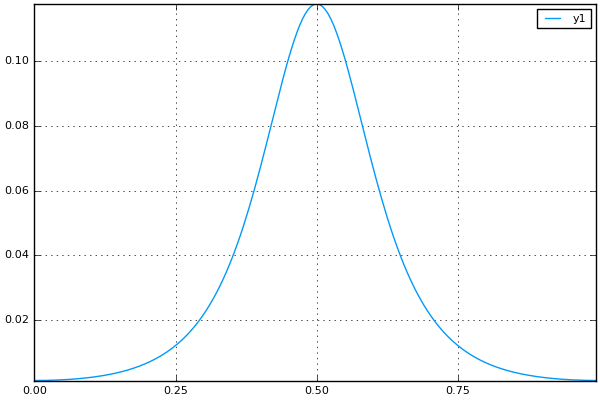

In [4]:
plot(x, real(diag(ρ)))


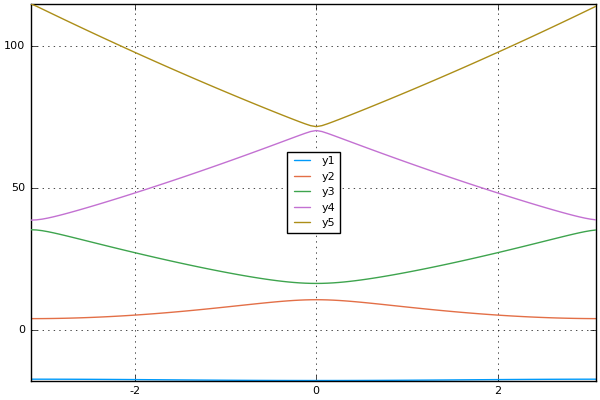

In [5]:
plot(k, E')